# 0.0 Imports

In [86]:
import math
import numpy               as np
import pandas              as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn             as sns
import xgboost             as xgb
import matplotlib.gridspec as gridspec

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML
from tabulate              import tabulate

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

## 0.1 Helper Functions

In [87]:
# v de cramer

def cramer_v( x, y):
    cm = pd.crosstab(x, y).values
    
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [88]:
def mean_percentage_error( y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error( y, yhat):
    return np.mean(np.abs ((y - yhat) / y))

def ml_error( model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])

In [89]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))

        #data inicio e fim de validação
        validation_start_date = x_training['date'].max() - datetime.timedelta(days= k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days= (k-1)*6*7)

        #filtragem do dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # dataset de treino e validação
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #modelo
        m = model.fit( xtraining, ytraining)

        #predição
        yhat = m.predict( xvalidation )

        #performance
        m_result = ml_error(model_name,np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])


In [90]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML ('<style..container {width:100% ! important;}</style>'))
    pd.options.display.max_columns= None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [91]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data

In [92]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [93]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
575813,144,5,2014-01-31,7616,759,1,0,0,0,a,c,16570.0,NaN,NaN,0,NaN,NaN,NaN


# 1.0 Descrição dos dados

In [94]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [95]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [96]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

#renomear
df1.columns = cols_new

In [97]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [98]:
#verifica o número de linhas e colunas

print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [99]:
## Verifica se os dados estão no tipo correto
df1['date'] = pd.to_datetime(df1['date'])

In [100]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [101]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [102]:
df1['competition_distance'].max()

75860.0

In [103]:
#competition_distance
#substitui os NA e matém os valores existentes nas demais 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                      
#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [104]:
df1.sample(5).T

,974208,246746,364701,787869,871859
store,484,96,274,350,715
day_of_week,5,6,6,4,6
date,2013-02-08 00:00:00,2014-12-20 00:00:00,2014-08-16 00:00:00,2013-07-25 00:00:00,2013-05-11 00:00:00
sales,8972,3690,3276,6030,2311
customers,853,338,782,520,257
open,1,1,1,1,1
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,1,0
store_type,a,a,b,d,a


## 1.6 Change Types

In [105]:
#Após fazer transformações em colunas é bom chegar para ver se o seu tipo não foi mudado 
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [106]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [107]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical 

In [108]:
num_attributes = df1.select_dtypes(include =['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'int32', 'datetime64[ns]'])

In [109]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
162907,118,6,7691,741,1,0,0,3580.0,9,2012,0,10,2015,0
149767,358,4,10598,1079,1,1,0,2890.0,10,2003,0,12,2015,0


## 1.7.1 Numerical Attributes

In [110]:
# Tendencia Central - Média e Mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T

# Dispersão - Desvio padrão, min, max, range (valor entre o min e o max), skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std) ).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#Concatenar essas métricas
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attributes','min','max','range','mean','median','std','skew','kurtosis'])
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


## 1.7.2 Categorical Attributes

In [111]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

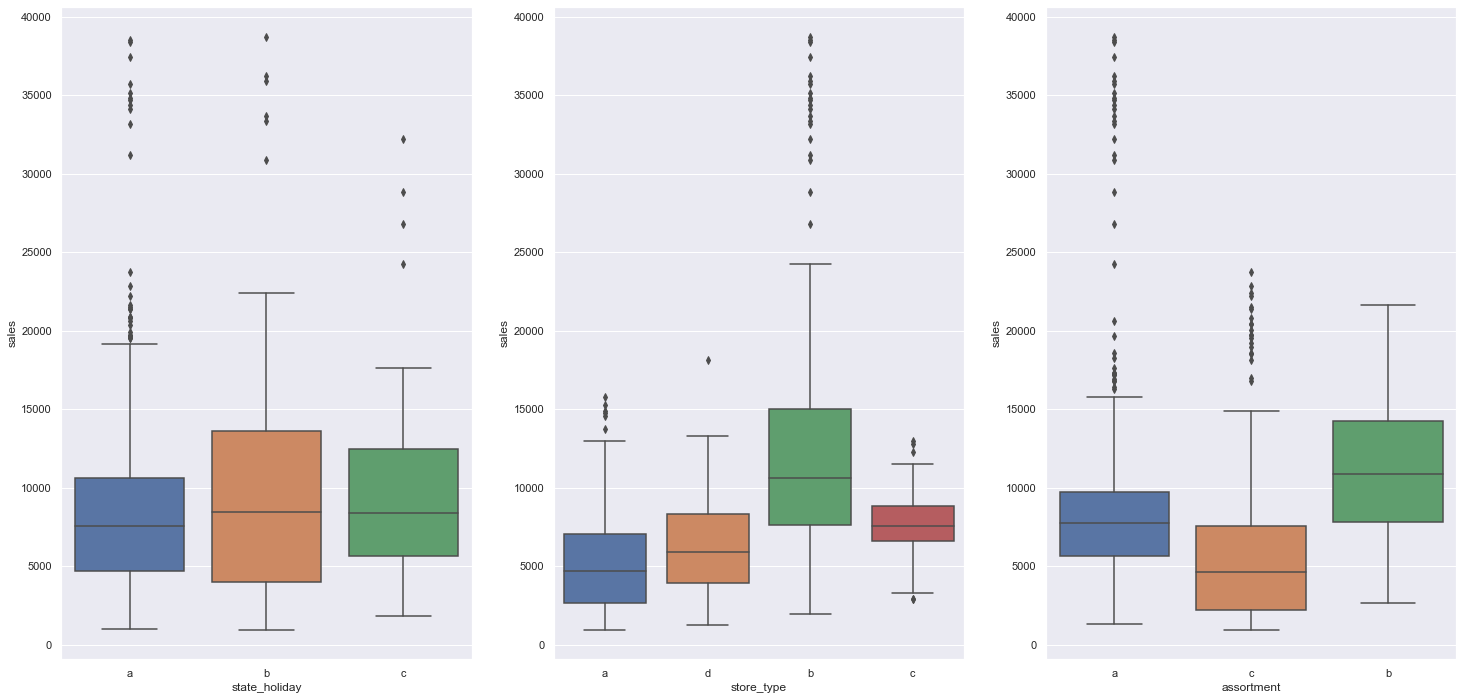

In [112]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Engennering

## 2.0.1 Mapa mental de hipóteses

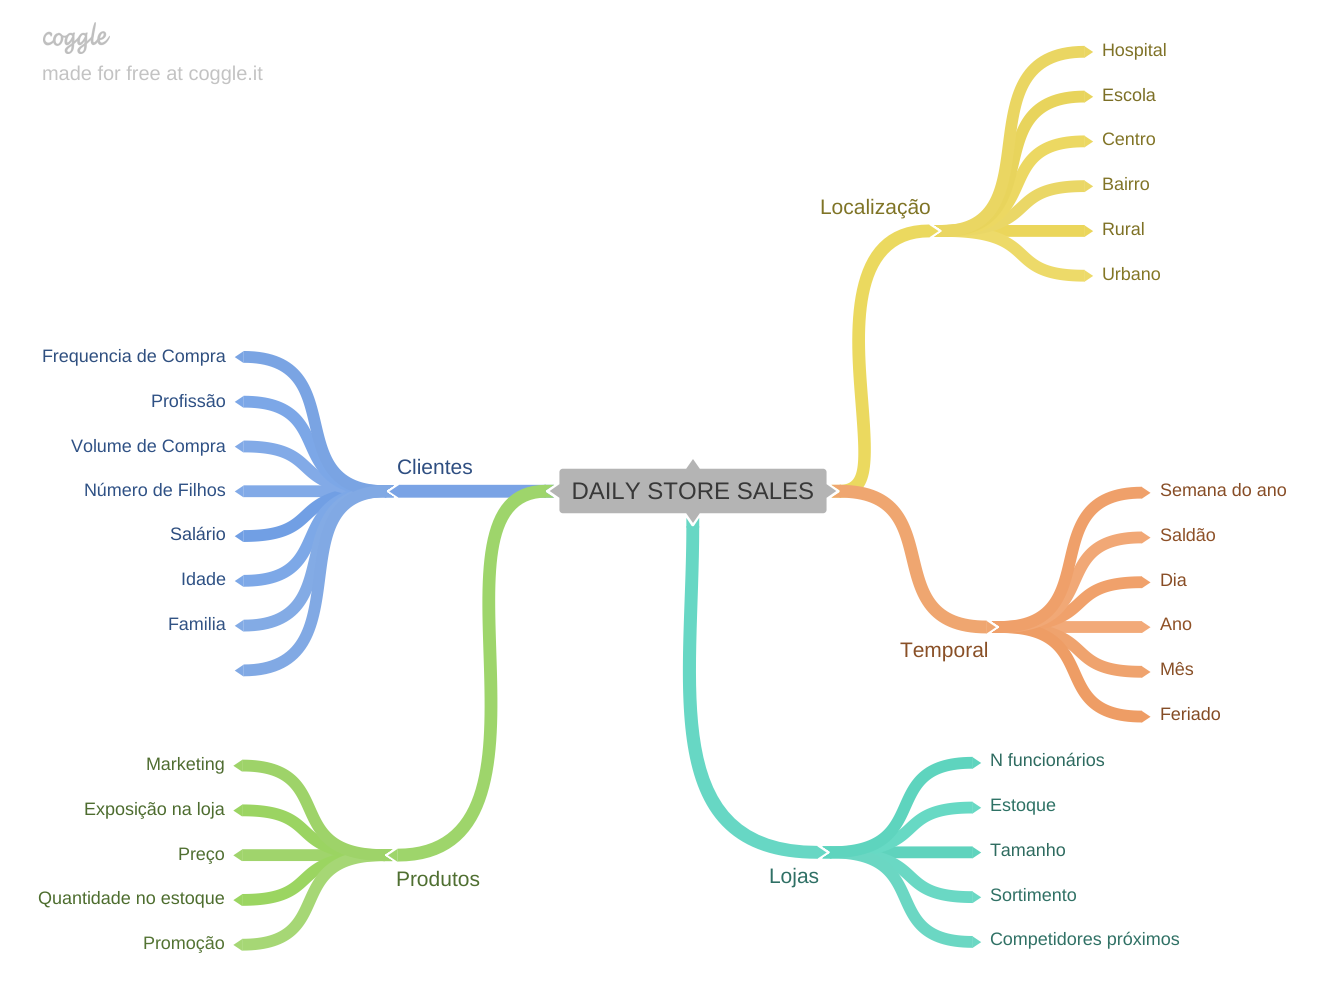

In [113]:
Image('../img/mind_map.png')

## 2.1 Crição de Hipóteses

### 2.1.1 Hipótese de Loja

In [114]:
# 1 Lojas com maior quadro de funcionário deveriam vender mais.

# 2 Lojas com maior capacidade de estoque deveriam vender mais.

# 3 Lojas com maior porte deveriam vender mais.

# 4 Lojas com maior sortimentos deveriam vender mais.

# 5 Lojas com competidores mais próximos deveriam vender menos.

# 6 Lojas com competidores à mais tempo deveriam vender mais.


### 2.1.2 Hipótese de Produto

In [115]:
# 1 Lojas que investem mais em marketing deveriam vender mais.

# 2 Lojas que expõe mais o produto nas vitrines deveriam vender mais.

# 3 Lojas que tem preços menores nos produtos deveriam vender mais.

# 5 Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

# 6 Lojas com promoções ativas por mais tempo deveriam vender mais.

# 7 Lojas com mais divas de promoção deveriam vender mais.

# 8 Lojas com mais promoções consecutivas deveriam vender mais.


### 2.1.3 Hipótese Temporal

In [116]:
# 1 Lojas abertas durante o feriado de natal deveriam vender mais.

# 2 Lojas deveriam vender mais ao longo dos anos.

# 3 Lojas deveriam vender mais no segundo semestre do ano.

# 4 Lojas deveriam vender mais depois do dia 10 de cada mês.

# 5 Lojas deveriam vender menos aos finais de semana.

# 6 Lojas deveriam vender menos durante os feriados escolares.

## 2.2 Lista final de hipóteses

In [117]:
# 1 Lojas com maior sortimentos deveriam vender mais.


# 2 Lojas com competidores mais próximos deveriam vender menos.


# 3 Lojas com competidores à mais tempo deveriam vender mais.


###################################################################
# 4 Lojas com promoções ativas por mais tempo deveriam vender mais.


# 5 Lojas com mais divas de promoção deveriam vender mais.


# 6 Lojas com mais promoções consecutivas deveriam vender mais.


##################################################################
# 7 Lojas abertas durante o feriado de natal deveriam vender mais.


# 8 Lojas deveriam vender mais ao longo dos anos.


# 9 Lojas deveriam vender mais no segundo semestre do ano.


# 10 Lojas deveriam vender mais depois do dia 10 de cada mês.


# 11 Lojas deveriam vender menos aos finais de semana.


# 12 Lojas deveriam vender menos durante os feriados escolares.

## 2.3 Feature Engineering

In [118]:
df2 = df1.copy()

In [119]:
# variáveis que vão ser derivadas da origintal
# ano
df2['year'] = df2['date'].dt.year

# mês
df2['month'] = df2['date'].dt.month

# dia
df2['day'] = df2['date'].dt.day

# semana do ano
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# semana do ano
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# ano competidor desde
df2['competition_since'] = df2.apply( lambda x: datetime.datetime (year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis =1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /30).apply(lambda x: x.days).astype(int)


# ano promoção desde
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta (days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days).astype(int)

# sortimento
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b'else 'extended')

# feriado estadual
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b'else 'christmas' if x == 'c'else 'regular_day')

In [120]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variáveis

In [121]:
df3 = df2.copy()

In [122]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem das linhas

In [123]:
df3 = df3[(df3['open'] != 0) &  (df3['sales'] > 0)]

## 3.2 Seleção das colunas

In [124]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [125]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise exploratória de dados

In [126]:
# Os 3 objetivos da análise exploratória de dados
# Ganhar experiência de negócio
# Validar hipóteses de negócio (insights)
# Perceber variáveis que são importantes para o modelo

In [127]:
df4 = df3.copy()
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1 Análise univariada

### 4.1.1 Response variable

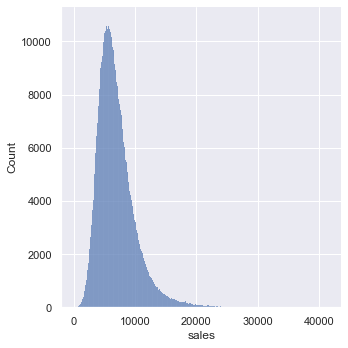

In [128]:
sns.displot(df4['sales'])

### 4.1.2 Numerical variable

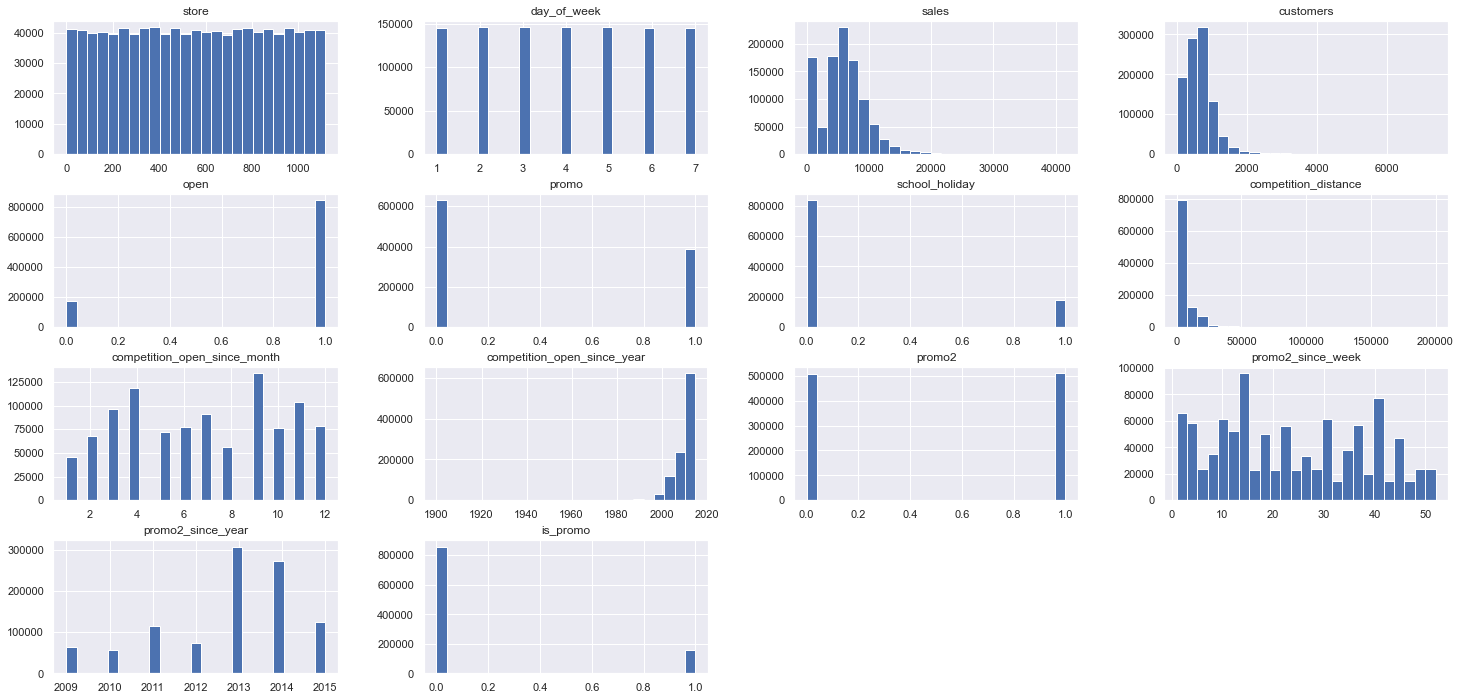

In [129]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical variable

In [130]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [131]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [132]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

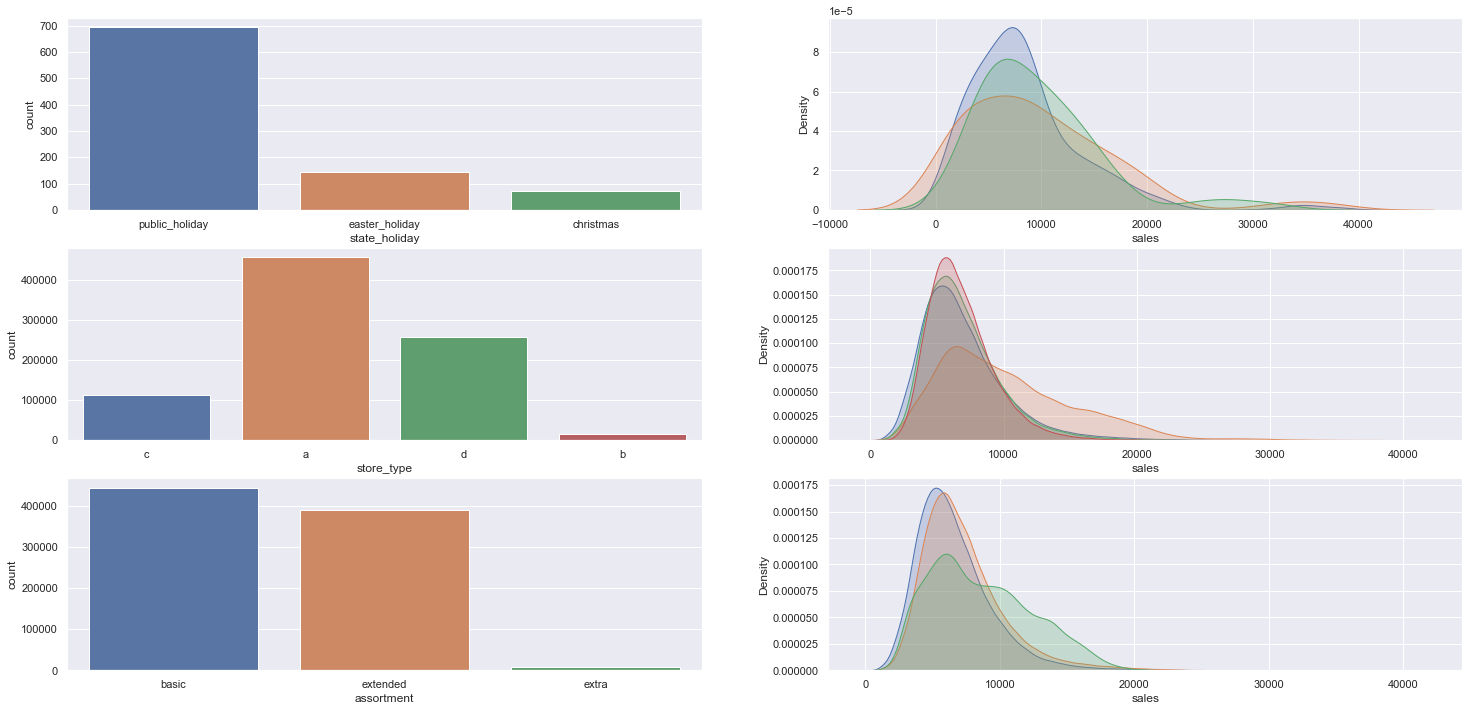

In [133]:
#state holiday
plt.subplot(3,2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot(3,2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3,2, 3)
sns.countplot( df4['store_type'] )

plt.subplot(3,2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3,2, 5)
sns.countplot( df4['assortment'] )

plt.subplot(3,2, 6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2 Análise bivariada

<AxesSubplot:xlabel='year_week'>

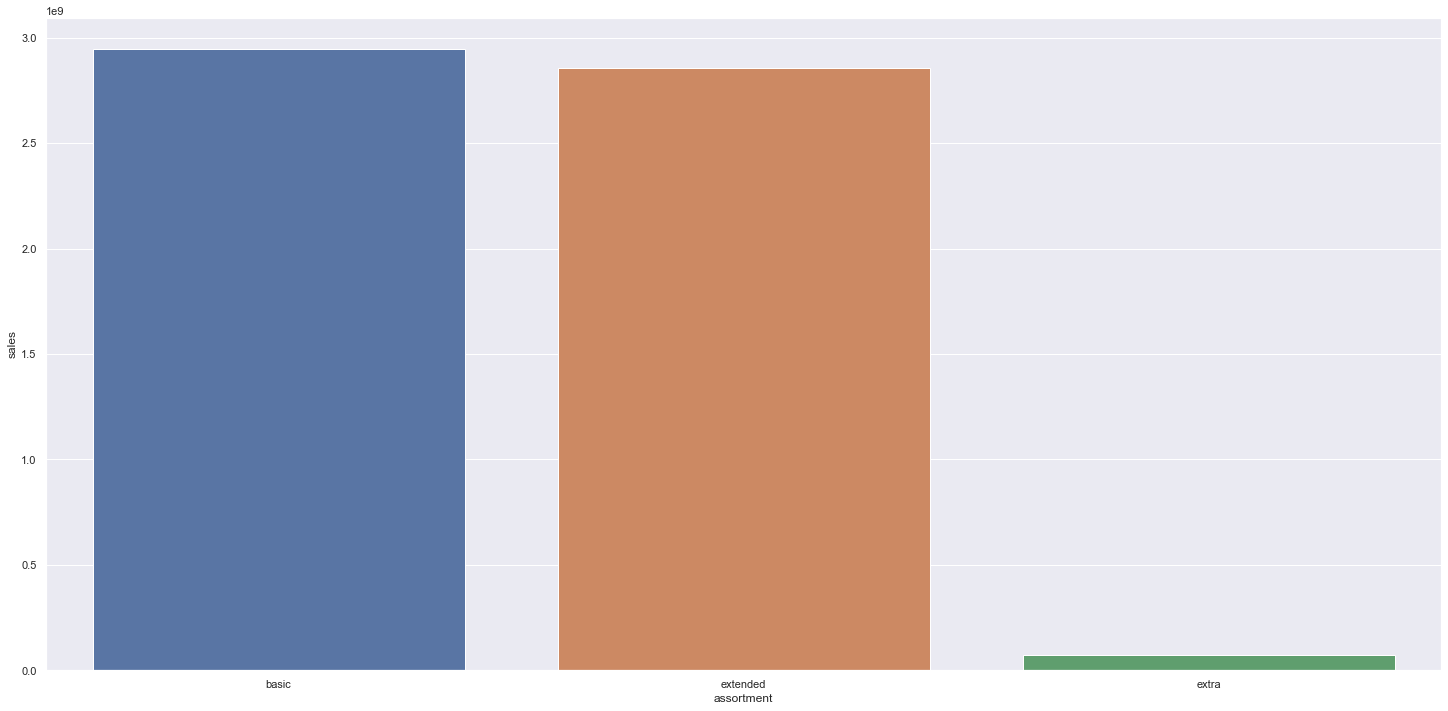

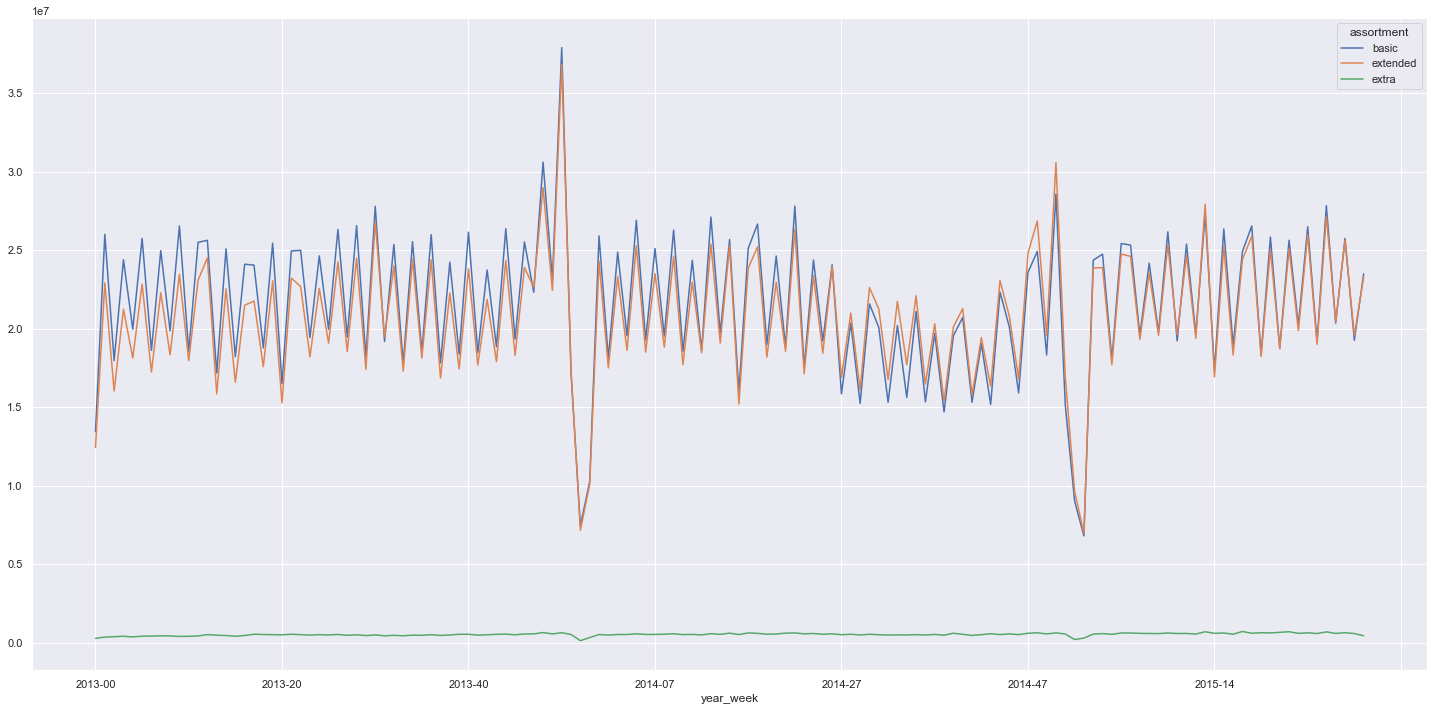

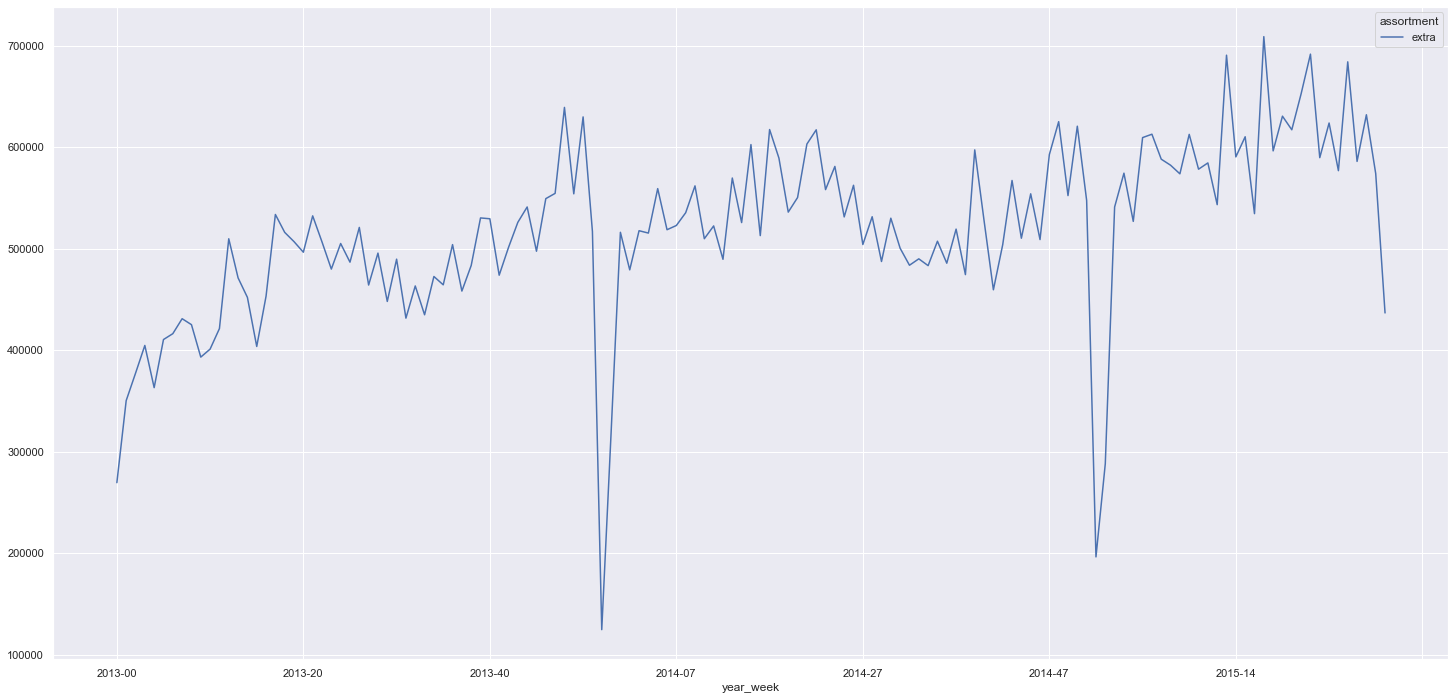

In [134]:
# 1 Lojas com maior sortimentos deveriam vender mais.
# Falso; lojas com maior sortimento (extra) vendem menos.

aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1);


aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()


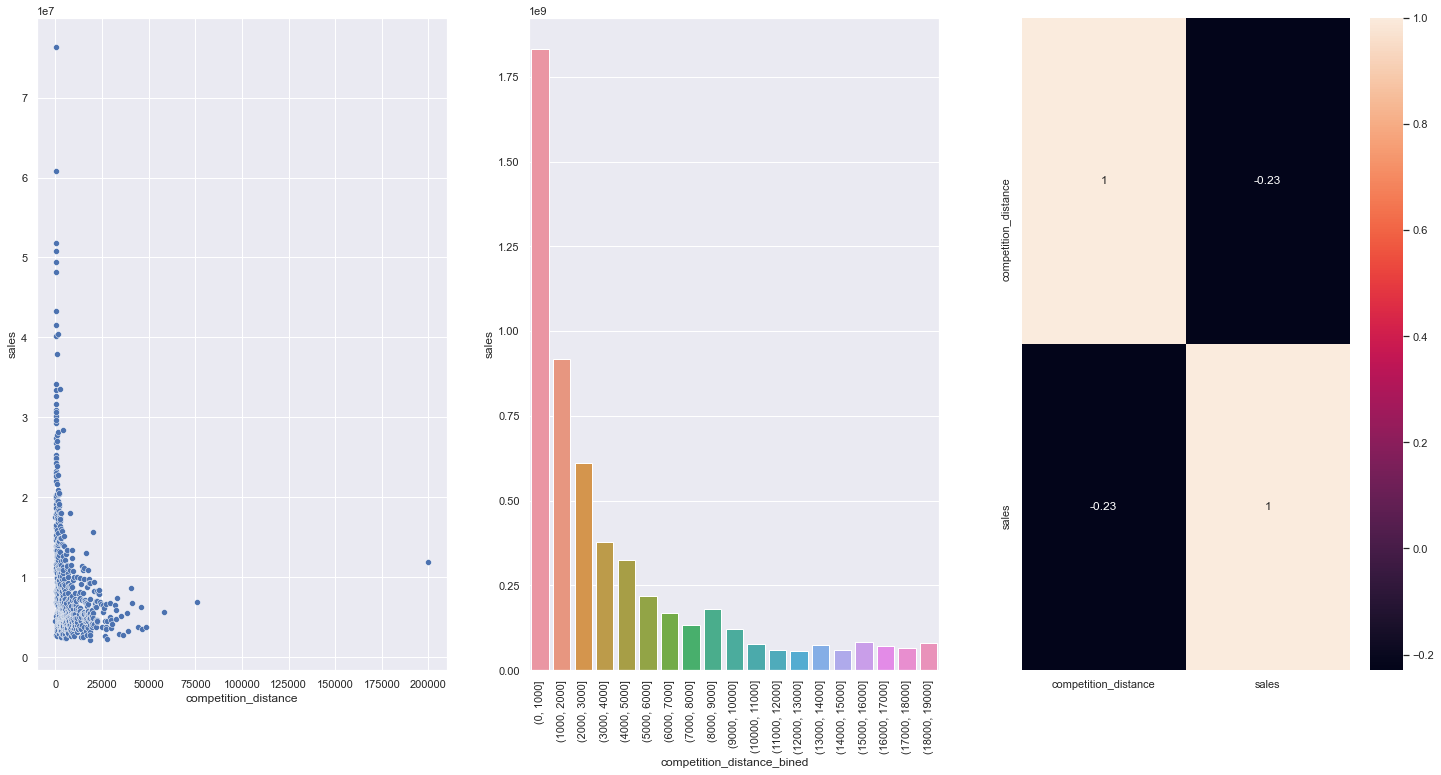

In [135]:
# 2 Lojas com competidores mais próximos deveriam vender menos.
# Falso; Na realidade lojas com competidores mais próximos, vendem mais e não menos.

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot (x ='competition_distance', y='sales', data=aux1);

plt.subplot (1, 3, 2)
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_bined'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_bined', 'sales']].groupby('competition_distance_bined').sum().reset_index()
sns.barplot(x='competition_distance_bined', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr( method='pearson'), annot=True );



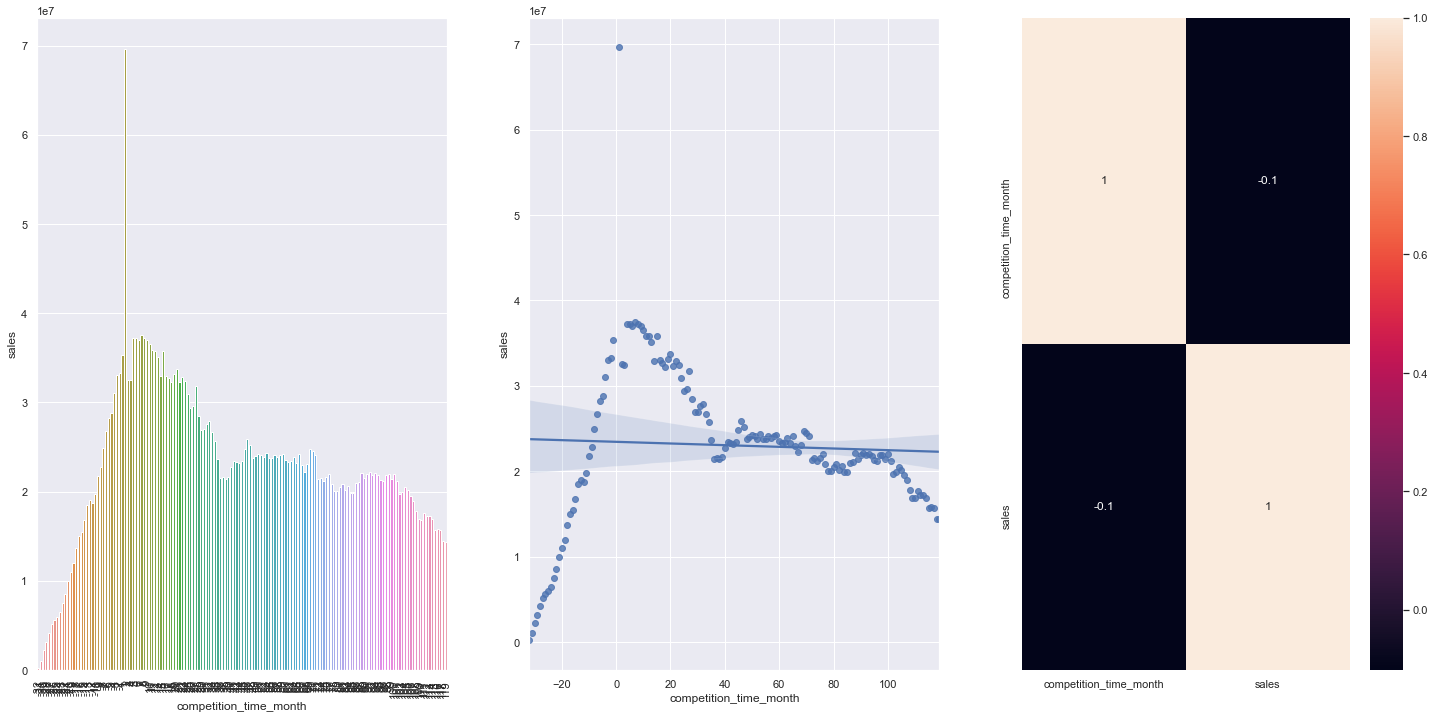

In [136]:
# 3 Lojas com competidores à mais tempo deveriam vender mais.
# Falso, lojas com competidores a mais tempo vendem menos;

plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks( rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);


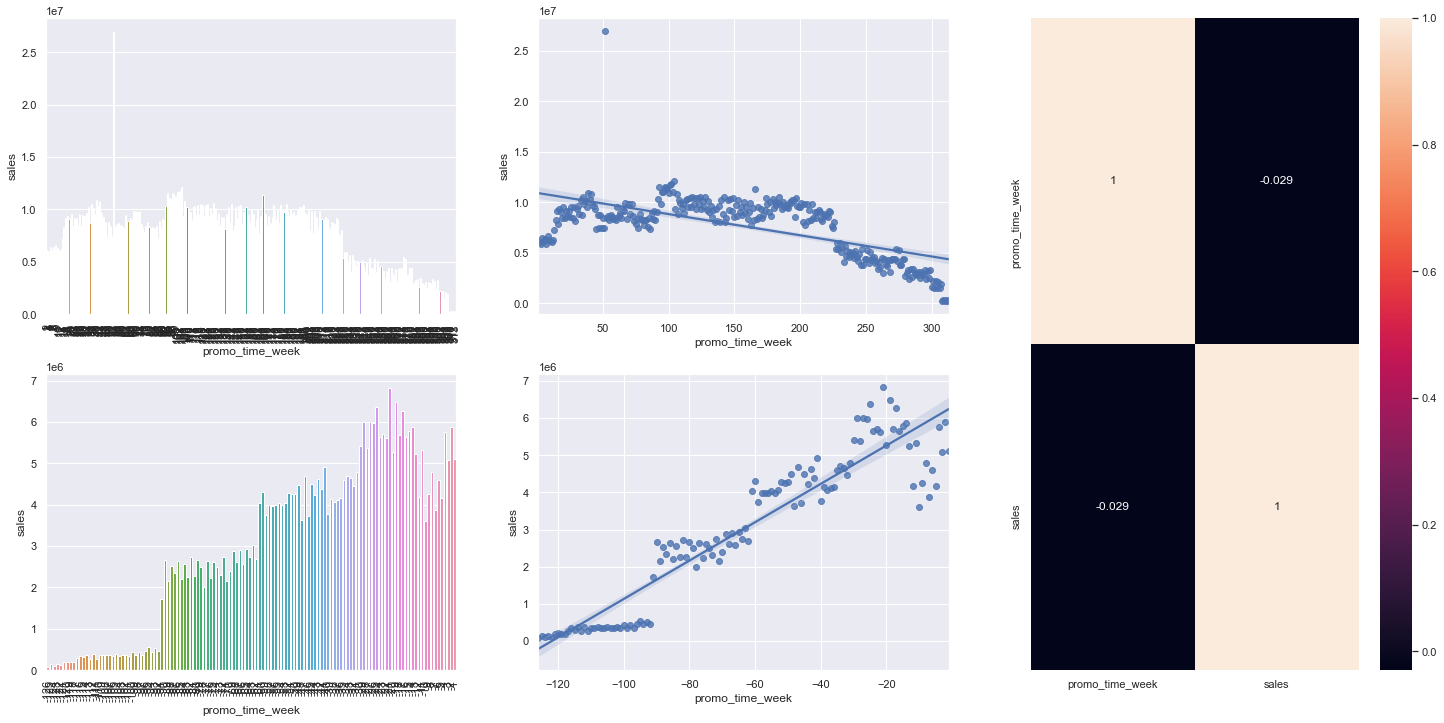

In [137]:
# 4 Lojas com promoções ativas por mais tempo deveriam vender mais.
# Falso, promoções ativas por mais tempo vendem regularmente durante um periodo e depois vai caindo.

aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #periodo extendido de promoção
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #periodo regular de promoção
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot( x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr( method='pearson'), annot=True);

In [138]:
# 5 Lojas com mais dias de promoção deveriam vender mais. **** validação no próximo ciclo ****


In [139]:
# 6 Lojas com mais promoções consecutivas deveriam vender mais.
# Falso,porque lojas com mais promoções consecutivas vendem menos.

df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


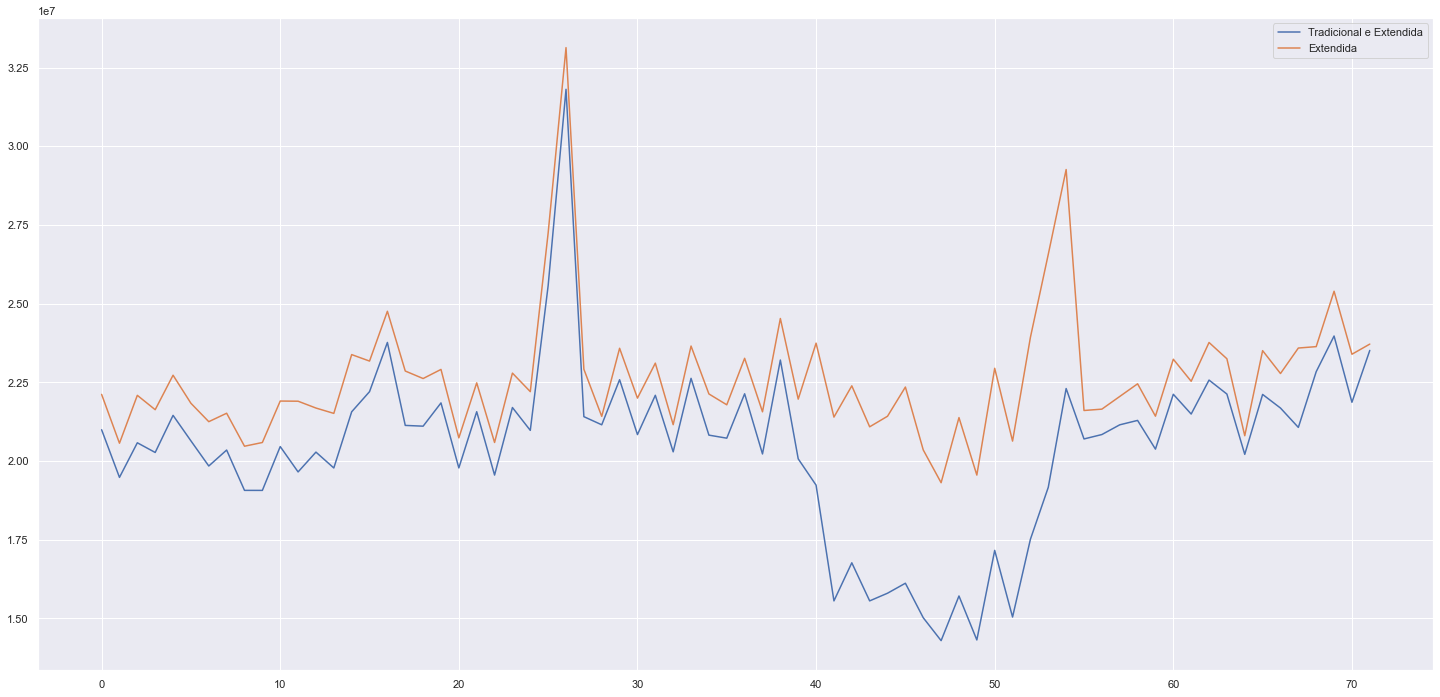

In [140]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida','Extendida']);

<AxesSubplot:xlabel='year', ylabel='sales'>

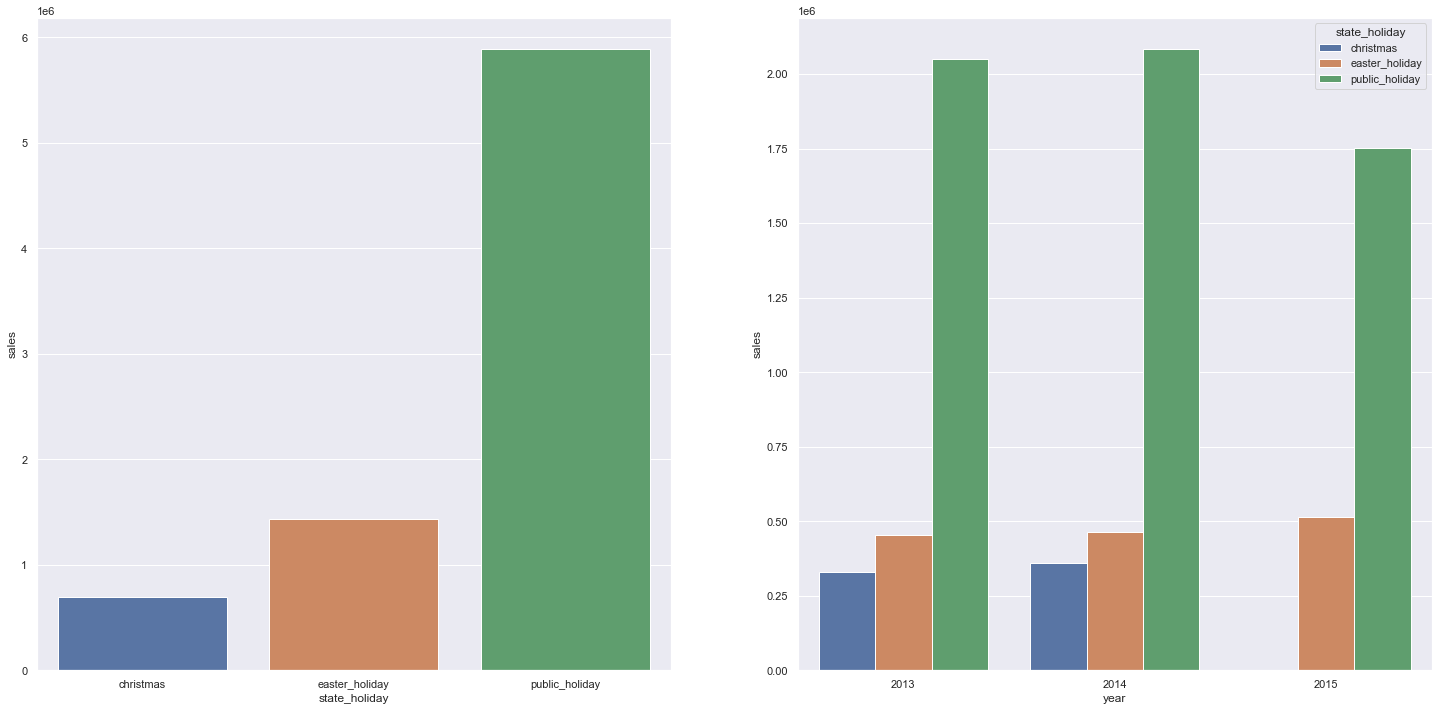

In [141]:
# 7 Lojas abertas durante o feriado de natal deveriam vender mais.
# falsa, porque lojas abertas durante o feriado do natal, vendem menos

aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y='sales', hue='state_holiday', data=aux2)

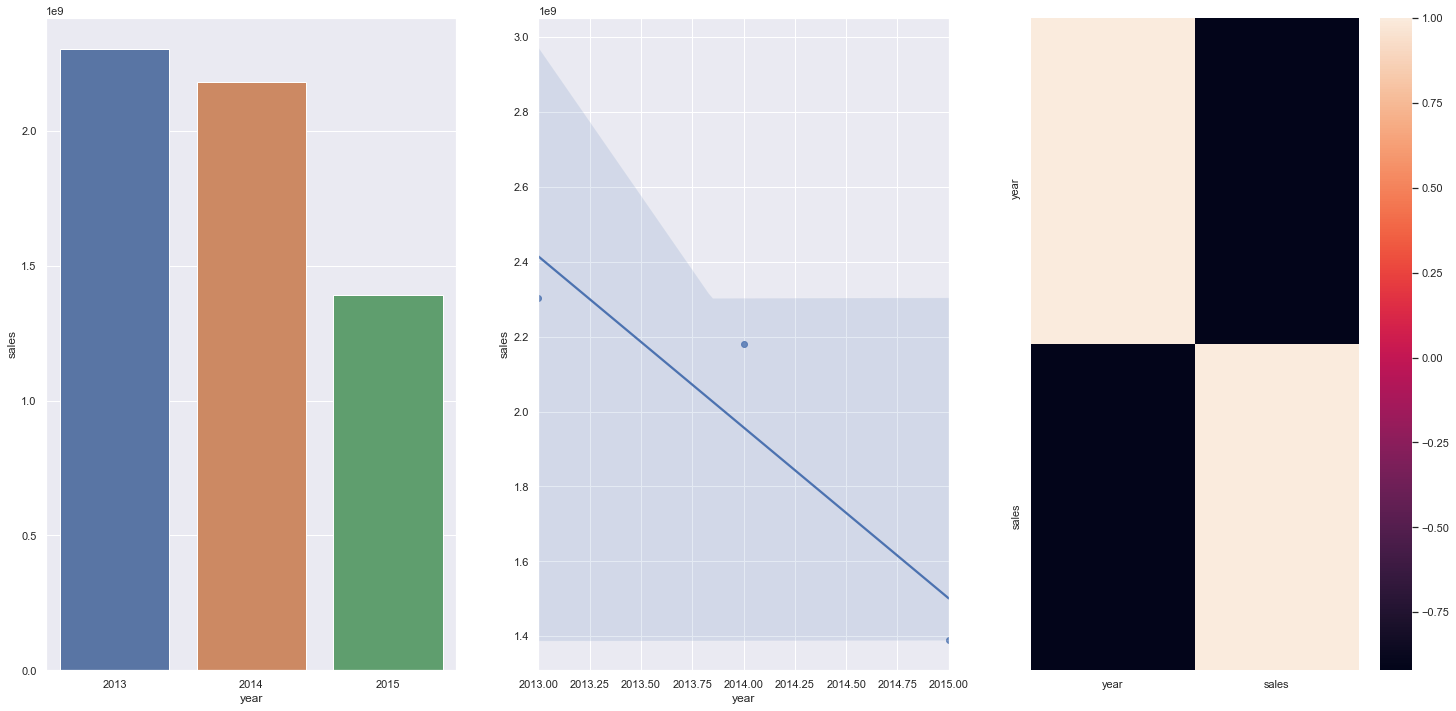

In [142]:
# 8 Lojas deveriam vender mais ao longo dos anos.
# Falsa, lojas vendem menos ao longo dos anos.

aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'));

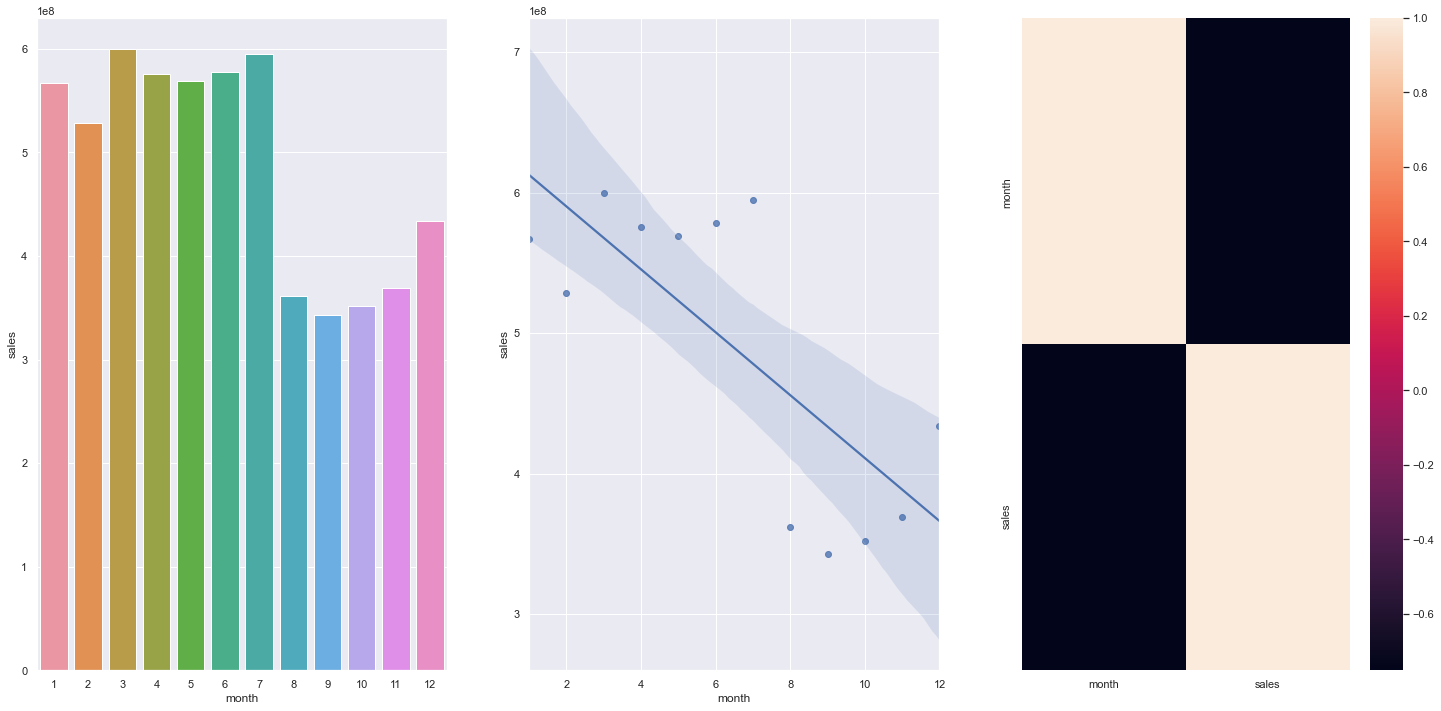

In [143]:
# 9 Lojas deveriam vender mais no segundo semestre do ano.
# Falso, as lojas vendem menos no segundo semestre do ano.

aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'));

<AxesSubplot:xlabel='before_after', ylabel='sales'>

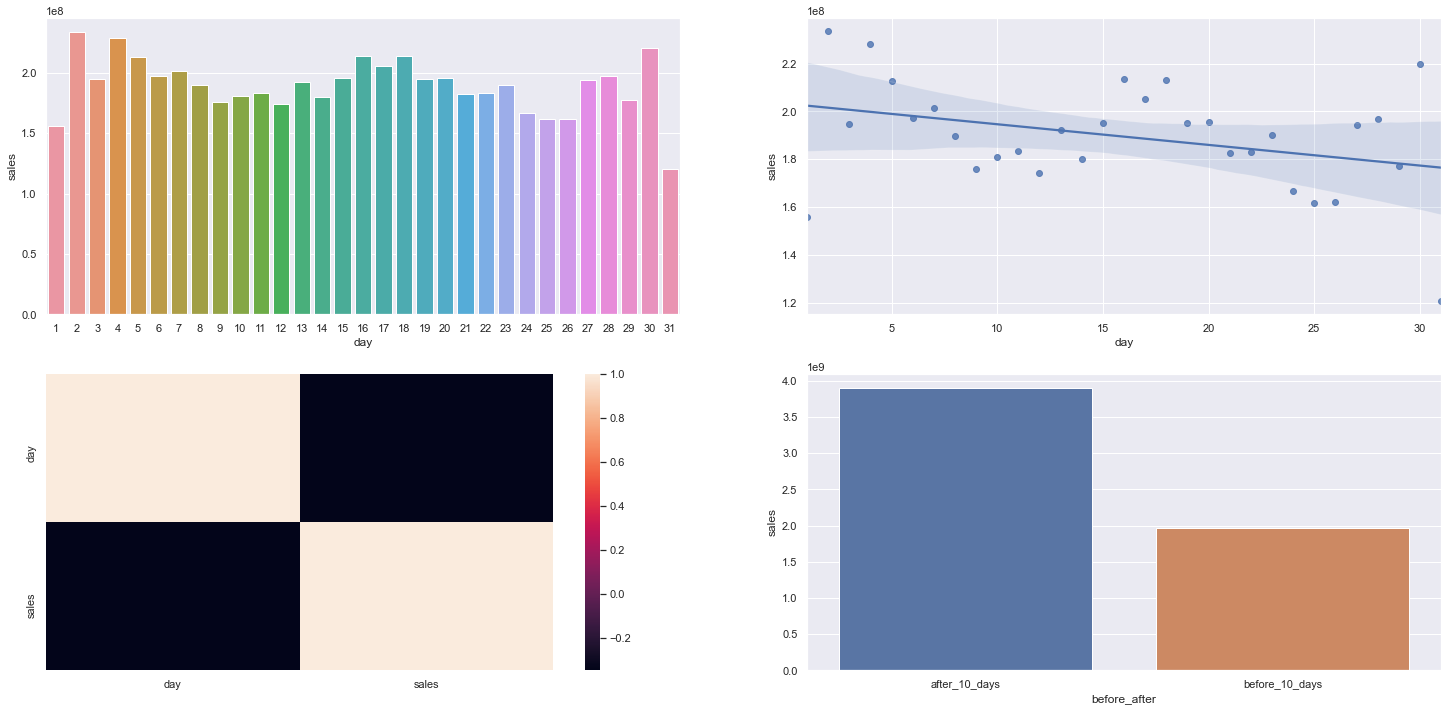

In [144]:
# 10 Lojas deveriam vender mais depois do dia 10 de cada mês.
# Verdadeira, lojas vendem mais depois do dia 10 de cada mês.

aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x = 'day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'));

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'before_after', y='sales', data=aux2)



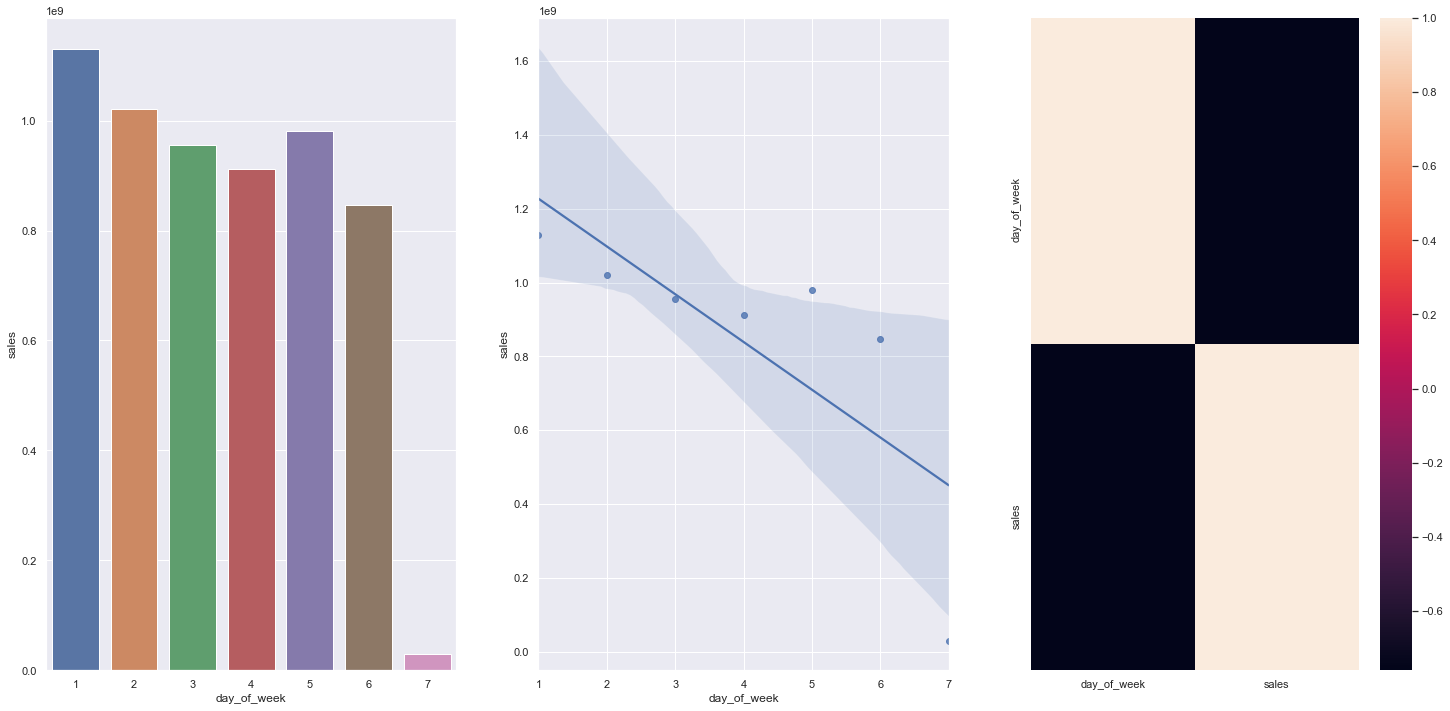

In [145]:
# 11 Lojas deveriam vender menos aos finais de semana.
# Verdade, as lojas vendem menos nos finais de semana.
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'));

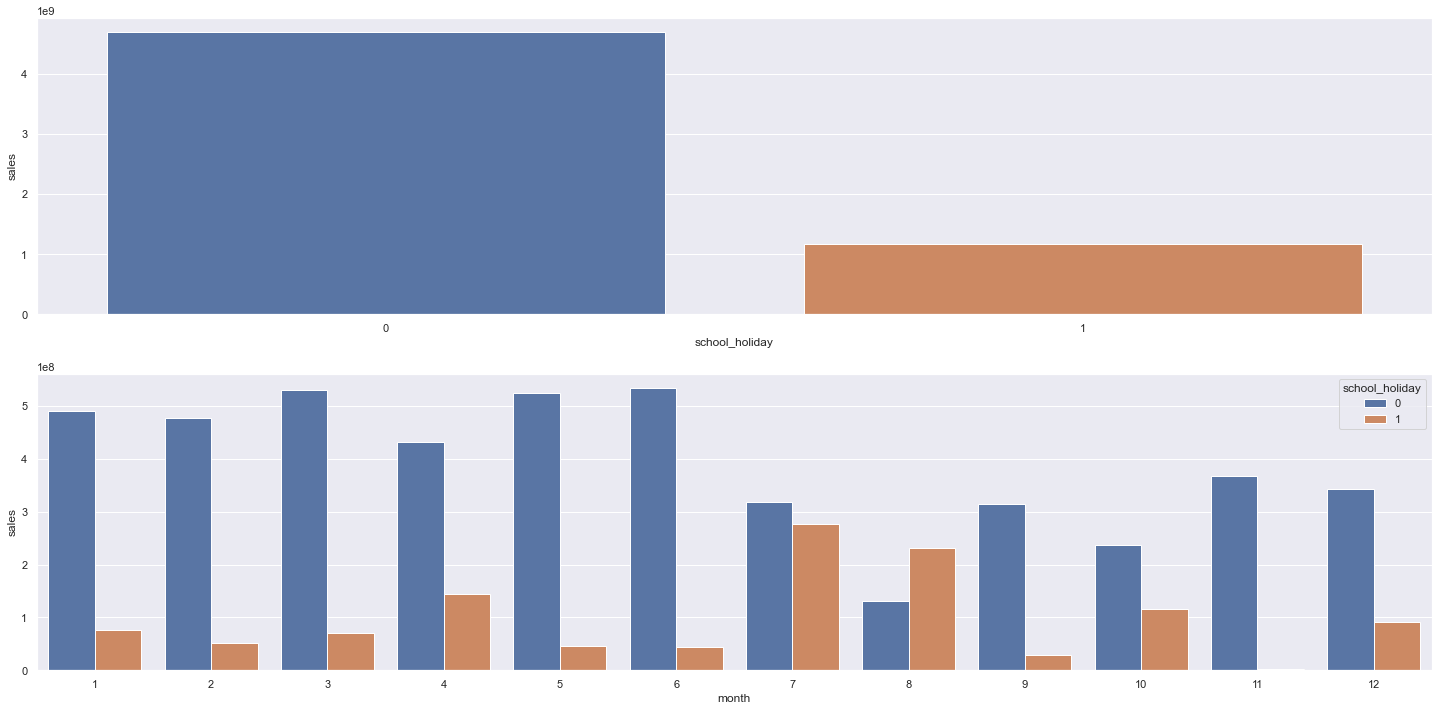

In [146]:
# 12 Lojas deveriam vender menos durante os feriados escolares.
# Verdadeira,lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto.

aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x ='school_holiday', y='sales', data=aux1);

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x ='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1 Resumo das Hipóteses

In [147]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
        ['H1','Falsa','Baixa'],
        ['H2','Falsa','Media'],
        ['H3','Falsa','Media'],
        ['H4','Falsa','Baixa'],
        ['H5','-','-'],
        ['H6','Falsa','Baixa'],
        ['H7','Falsa','Media'],
        ['H8','Falsa','Alta'],
        ['H9','Falsa','Baixa'],
        ['H10','Verdadeira','Alta'],
        ['H11','Verdadeira','Alta'],
        ['H12','Verdadeira','Baixa'],
      ]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Baixa
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## 4.3 Análise multivariada

### 4.3.1 Atributos numéricos

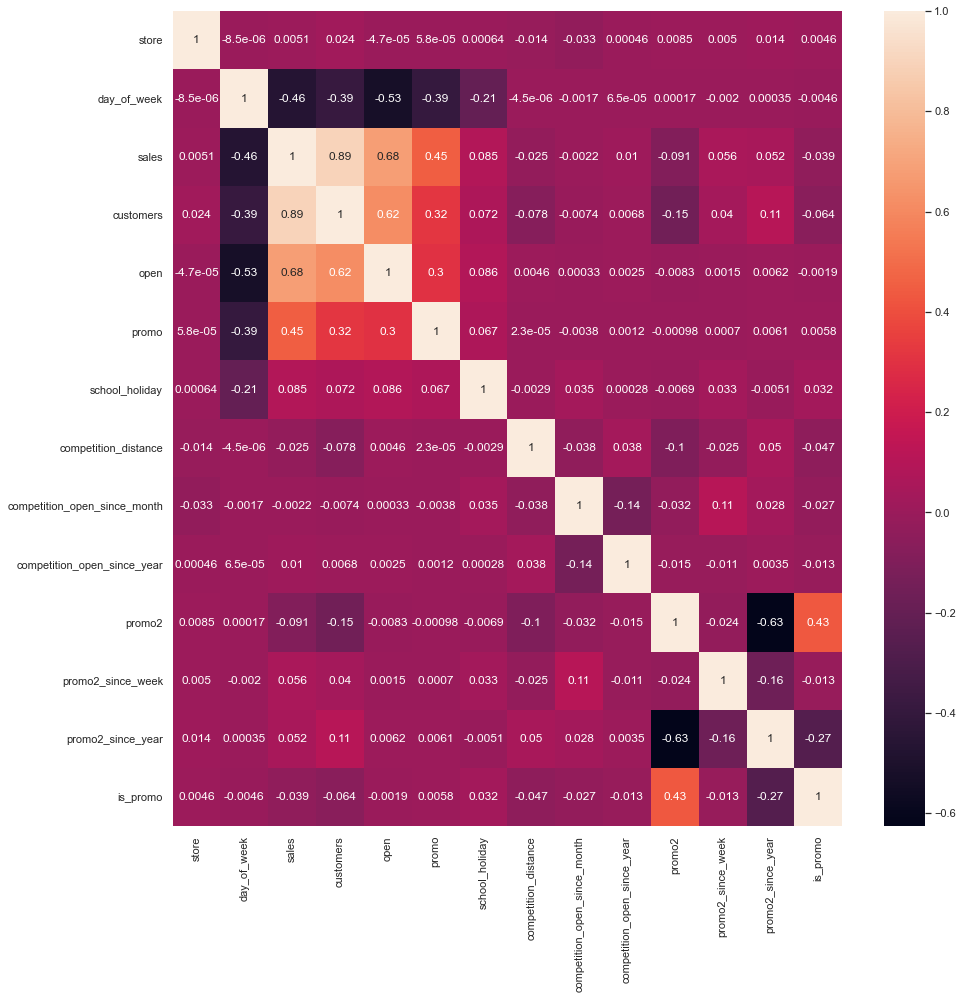

In [148]:
plt.rcParams['figure.figsize']=(15,15)
correlation = num_attributes.corr(method='pearson')
sns.heatmap( correlation, annot=True);

### 4.3.2 Atributos categóricos

<AxesSubplot:>

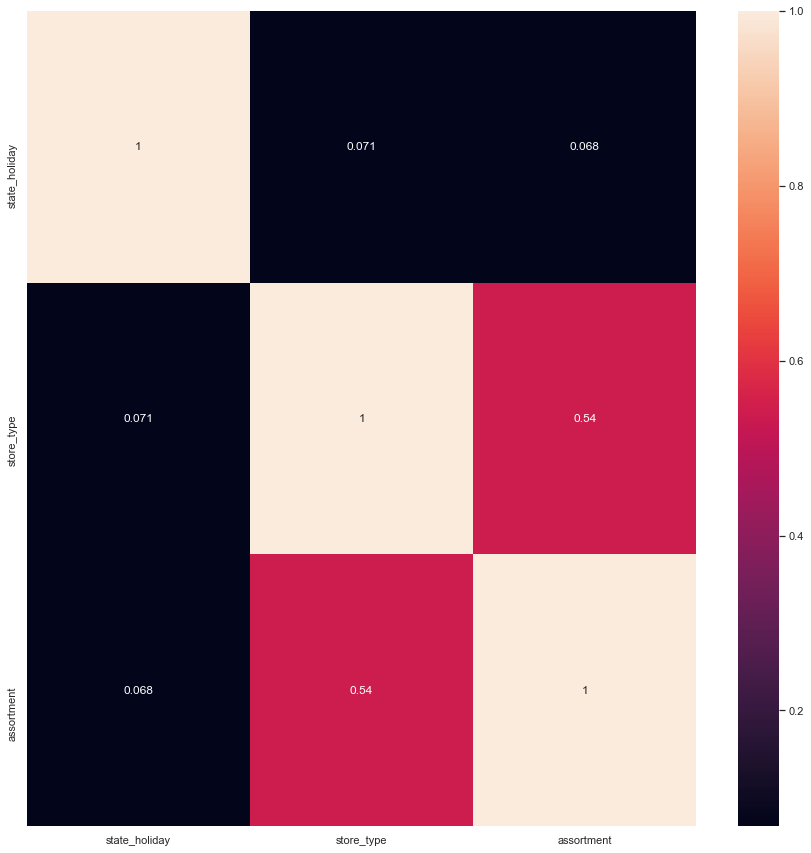

In [149]:
#Somente dados categóricos
a = df4.select_dtypes(include='object')

# calcula v cramer
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Datasset final
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9],})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5. Preparação dos Dados

In [150]:
df5 = df4.copy()

In [151]:
# chance types df5 

df5['week_of_year'] = df5['week_of_year'].astype(int)

## 5.1 Normalização

In [152]:
# Não foi achado variáveis para normalizar

## 5.2 Rescaling

In [153]:
a = df5.select_dtypes( include=['int64', 'float64','int32'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [154]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl','wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)
pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl','wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)
pickle.dump(rs, open('../parameter/promo_time_week_scaler.pkl','wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values)
pickle.dump(mms, open('../parameter/year_scaler.pkl','wb'))

## 5.3 Transformação

### 5.3.1 Encoding

In [155]:
# variáveis categóricas
#state holiday | One hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type | label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb'))

#assortment | ordinal encoding
#df5['assortment'].drop_duplicates()
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Transformação de variável resposta

In [156]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Transformação de natureza

In [157]:
#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

In [158]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6. Seleção de variáveis

In [159]:
df6 = df5.copy()

## 6.1 Divisão do dataframe em treinamento e conjunto de dados de teste

In [160]:
cols_drop=['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis=1)

In [161]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=6*7 ) #intervalo de 6 weeks

Timestamp('2015-06-19 00:00:00')

In [162]:
#dataset de treinamento
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#dataset de teste
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min date: {}'.format( X_train['date'].min()))
print('Training Max date: {}'.format( X_train['date'].max()))

print('\nTest Min date: {}'.format( X_test['date'].min()))
print('Test Max date: {}'.format( X_test['date'].max()))

Training Min date: 2013-01-01 00:00:00
Training Max date: 2015-06-18 00:00:00

Test Min date: 2015-06-19 00:00:00
Test Max date: 2015-07-31 00:00:00


## 6.2 Boruta como seletor

In [163]:
#NÃO FICAR RODANDO DIRETO POIS DEMORA MUITO
##training and test dataset for boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#Y_train_n = Y_train.values.ravel()

##define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1)

## define boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit( X_train_n, Y_train_n)

In [164]:
#cols_selected = boruta.support_.tolist()

##best features do boruta
#X_train_fs = X_train.drop(['date','sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[: , cols_selected].columns.to_list()

#colunas não selecionadas pelo boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [165]:
#cols_selected_boruta

In [166]:
#cols_not_selected_boruta

## Seleção Manual de Features 

In [167]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']

# colunas adicionadas
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

#cols_selected_boruta.extend(feat_to_add)

In [168]:
cols_not_selected_boruta = [
    'is_promo',
    'school_holiday',
    'state_holiday_christmas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day',
    'year']

# 7. Machine Learning Modelling

In [169]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Preparação de dados Time Series
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [170]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Reegression Model

In [171]:
# model
lr = LinearRegression().fit( x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


#### 7.2.1 Linear Regression Model - Cross Validation

In [172]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)

In [173]:
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Reegression Regularized Model - Lasso

In [175]:
# model
lrr = Lasso(alpha=0.01).fit( x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1891.704881,0.289106,2744.451737


#### 7.3.1 Linear Regression Regularized Model  - Lasso - Cross Validation

In [176]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression Regularized - Lasso', lrr, verbose=False)

In [177]:
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE
0,Linear Regression Regularized - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## Modelos Não-Lineares

## 7.4 Random Forest Regressor

In [178]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Randon Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Randon Forest Regressor,679.598831,0.099913,1011.119437


#### 7.4.1 Random Forest Regressor - Cross Validation

In [179]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [180]:
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17


## 7.5 XGBoost Regressor

In [182]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit( x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.423528,0.949439,7330.693347


#### 7.5.1 XGBoost Regressor - Cross Validation

In [183]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


In [184]:
xgb_result_cv

,Model Name,MAE CV,MAPE CV,RMSE
0,XGBoost Regressor,7049.2 +/- 588.65,0.95 +/- 0.0,7715.2 +/- 689.51


## 7.6 Comparação da performance dos modelos

### 7.6.1 Single Performance

In [185]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result ])
modelling_result.sort_values( 'RMSE')

,Model Name,MAE,MAPE,RMSE
0,Randon Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6683.423528,0.949439,7330.693347


### 7.6.2 Real Performance - Cross Validation

In [186]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Linear Regression Regularized - Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,836.61 +/- 217.1,0.12 +/- 0.02,1254.3 +/- 316.17
0,XGBoost Regressor,7049.2 +/- 588.65,0.95 +/- 0.0,7715.2 +/- 689.51


In [187]:
# A random forest tem uma performance melhor se comparada com os outros modelos

# 8.Hyperparameter Fine Tunning

## 8.1 Random Search

In [188]:
param = {
    'n_estimators':[1500, 1700, 2500, 3000, 3500],
    'eta':[0.01, 0.03],
    'max_depth':[3, 5, 9],
    'subsample':[0.1, 0.5, 0.7],
    'colsample_bytree':[0.3, 0.7, 0.9],
    'min_child_weight':[3, 8, 15]
    }

MAX_EVAL = 10

In [189]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    # escolha de valores para parametros aleatoriamente
    hp = { k: random.sample(v, 1)[0] for k, v in param.items() }
    print(hp)
    
    # model Xgboost
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimators = hp[ 'n_estimators' ],
                                 eta = hp[ 'eta' ],
                                 max_depth = hp[ 'max_depth' ],
                                 subsample = hp[ 'subsample' ],
                                 colsample_bytree = hp[ 'colsample_bytree' ],
                                 min_child_weight = hp[ 'min_child_weight' ])

    # performance
    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
    final_result = pd.concat([final_result, result])
                                        
final_result

TypeError: random_sample() takes at most 1 positional argument (2 given)

## 8.2 Final Model

In [ ]:
param_tuned = {
    'n_estimators': 3500 ,
    'eta': 0.01,
    'max_depth': 3,
    'subsample': 0.7,
    'colsample_bytree': 0.3,
    'min_child_weight': 8 
    }

In [ ]:
# model Xgboost
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                     n_estimators = param_tuned[ 'n_estimators' ],
                                     eta = param_tuned[ 'eta' ],
                                     max_depth = param_tuned[ 'max_depth' ],
                                     subsample = param_tuned[ 'subsample' ],
                                     colsample_bytree = param_tuned[ 'colsample_bytree' ],
                                     min_child_weight = param_tuned[ 'min_child_weight' ]).fit( x_train, Y_train)
#prediciton
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb_tuned) )
xgb_result_tuned 

## MPE

In [ ]:
mpe = mean_percentage_error( np.expm1(Y_test), np.expm1( yhat_xgb_tuned))

# 9.0 Traduçao e interpretaçao do erro

In [ ]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1( df9['sales'])
df9['predictions'] = np.expm1( yhat_xgb_tuned)

## 9.1 Business Performance

In [132]:
# Somar prediçoes

df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#MERGE
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(d91, df9_aux3, how='inner', on='store')

#Cenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#Ordenar Colunas
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [133]:
df92.sort_values('MAPE',ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
472,473,286355.187500,281895.100955,290815.274045,4460.086545,1.415301
424,425,263702.843750,259739.523543,267666.163957,3963.320207,1.340466
969,970,200969.796875,198318.937579,203620.656171,2650.859296,1.157230
434,435,227809.625000,224643.445972,230975.804028,3166.179028,1.080435
487,488,275184.625000,271484.148292,278885.101708,3700.476708,1.013056


In [134]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,195394.046875,194492.756400,196295.337350,901.290475,0.204253
1,2,184749.109375,184177.835581,185320.383169,571.273794,0.123324
2,3,234542.796875,233730.718130,235354.875620,812.078745,0.118128
3,4,310884.312500,309303.401803,312465.223197,1580.910697,0.154828
4,5,179656.140625,179059.111025,180253.170225,597.029600,0.185243


<AxesSubplot:xlabel='store', ylabel='MAPE'>

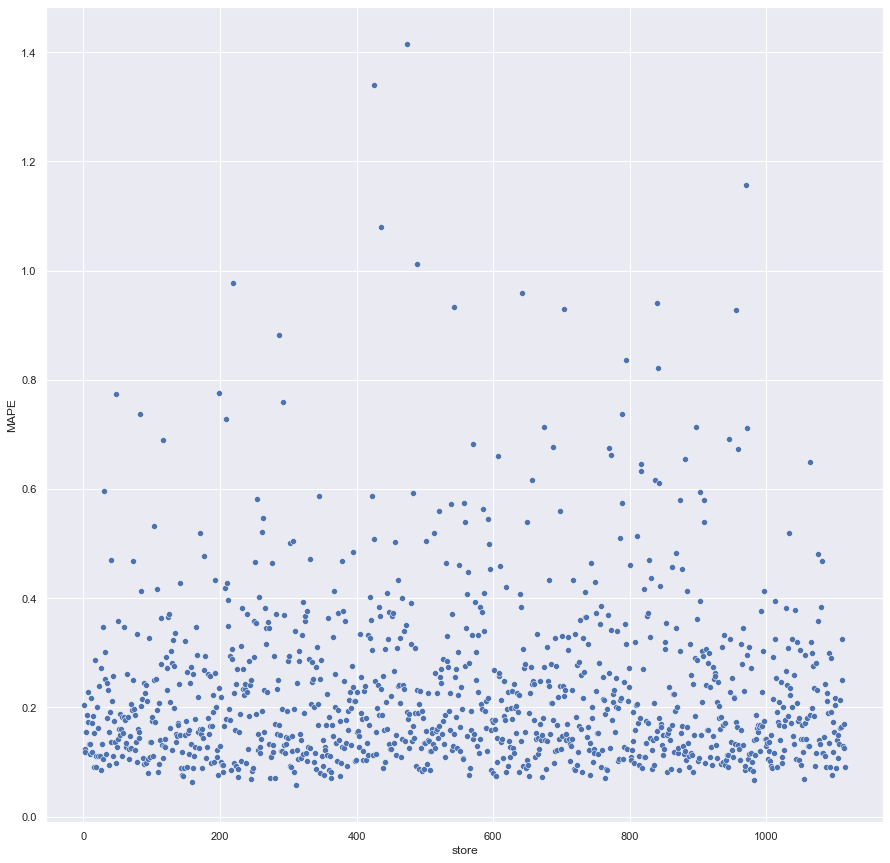

In [136]:
sns.scatterplot( x='store', y='MAPE', data=df92)

## 9.2 Total Performance

In [146]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$276,720,832.00"
1,worst_scenario,"R$275,034,658.03"
2,best_scenario,"R$278,407,052.90"


## 9.3 Machine Learning Performance

In [148]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

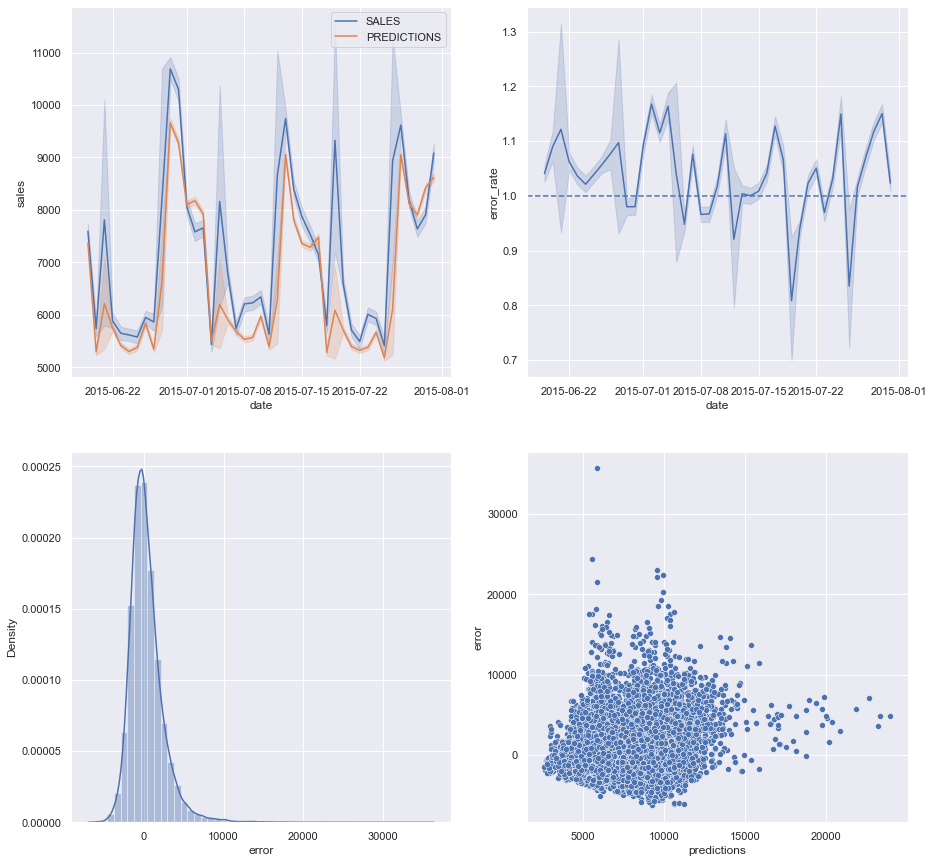

In [149]:
plt.subplot(2, 2 , 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2 , 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2 , 3)
sns.distplot(df9['error'])

plt.subplot(2, 2 , 4)
sns.scatterplot(df9['predictions'], df9['error'])

# 10 Modelo de Produção

In [187]:
#Salvar modelo treinado
pickle.dump( model_xgb_tuned, open('model/model_rossmann.pk1', 'wb'))

## 10.1 Rossmann Class

In [2]:
class Rossmann( object ):
    def __init__(self):
        self.competition_distance_scaler = pickle.load(open('parameter/competition_distance_scaler.pkl','rb'))
        self.competition_time_month_scaler = pickle.load(open('parameter/competition_time_month_scaler.pkl','rb'))
        self.promo_time_week_scaler = pickle.load(open('parameter/promo_time_week_scaler.pkl','rb'))
        self.year_scaler = pickle.load(open('parameter/year_scaler.pkl','rb'))
        self.store_type_scaler = pickle.load(open('parameter/store_type_scaler.pkl', 'rb'))
    
    def data_cleaning(self, df1):
        # 1.1 Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                    'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list(map(snakecase, cols_old))

        #renomear
        df1.columns = cols_new

        ## 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        
        ## 1.5 Fillout NA
        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


        #promo2_since_year
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval
        month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

        df1['promo_interval'].fillna(0, inplace = True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

        ## 1.6 Change Types

        #Após fazer transformações em colunas é bom chegar para ver se o seu tipo não foi mudado 
        df1.dtypes

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1

    def feature_engineering( self, df2):
        # ano
        df2['year'] = df2['date'].dt.year

        # mês
        df2['month'] = df2['date'].dt.month

        # dia
        df2['day'] = df2['date'].dt.day

        # semana do ano
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # semana do ano
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # ano competidor desde
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime (year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis =1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /30).apply(lambda x: x.days).astype(int)


        # ano promoção desde
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta (days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days).astype(int)

        # sortimento
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b'else 'extended')

        # feriado estadual
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b'else 'christmas' if x == 'c'else 'regular_day')

        ## 3.1 Filtragem das linhas
        df2 = df2[(df2['open'] != 0) &  (df2['sales'] > 0)]

        ## 3.2 Seleção das colunas
        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis=1)
        
        return d2
    
    def data_preparation (self, df5):
        
        # chance types df5 
        df5['week_of_year'] = df5['week_of_year'].astype(int)

        ## 5.2 Rescaling
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values)
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values)

        ### 5.3.1 Encoding
        # variáveis categóricas
        #state holiday | One hot encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        #store_type | label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        #assortment | ordinal encoding
        #df5['assortment'].drop_duplicates()
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3 Transformação de natureza
        #day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance',
             'competition_open_since_month','competition_open_since_year','promo2','promo2_since_week',
             'promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos',
             'month_sin','month_cos','day_sin','day_cos', 'week_of_year_sin','week_of_year_cos']
    
        return df5[cols_selected]

## 10.2 API Handler

In [4]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#carrega modelo
model = pickle.load(open('/Users/Rodrigo/Repos/Rossmann-store-sales-project/model/model_rossmann.pkl', 'rb'))

app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #tem dados
        if isinstance(test_json, dict): #unico exemplo
            test_raw = pd.DataFrame( test_json, index=[0])
            
        else: #varios exemplos
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys())
            
        #instanciar a classe rossmann
        pipeline = Rossmann()

        # limpeza dos datos
        df1 = pipeline.data_cleaning( test_raw )

        #feature engineering
        df2 = pipeline.feature_engineering( df1 )

        #preparação dos dados
        df3 = pipeline.data_preparation(df2)

        #prediction
        df_response = pipeline.get_prediction( model, test_raw, df3)
        
        return df_response
    
    else: #não tem dados
        return Response('{}', status=200, mimetype='application/json')


if __name__ == '__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossmann'

## 10.3 API Teste